In [1]:
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU
from keras.layers import Activation, Conv2D, Lambda, Concatenate, Flatten, Dense, UpSampling2D

from keras.utils import np_utils
import keras
import colorsys
import keras.backend as K
import glob
import json
from sklearn.model_selection import train_test_split
from io import BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

import math
import random

import numpy as np
import matplotlib.pyplot as plt

import cv2
from keras.utils.vis_utils import plot_model

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:461: FutureWarning: Passing (type, 1) or 

In [2]:
# 配置必要的参数，路径
BATCH_SIZE = 32
LATENT_SIZE = 128
import os
path = os.getcwd()+'/data/icons'

In [3]:
# 数据准备，并进行数据增强。
def augment(icons):
    aug_icons = []
    for icon in icons:
        for flip in range(4):
            for rotation in range(4):
                aug_icons.append(icon)
                icon = np.rot90(icon)
            icon = np.fliplr(icon)
    return np.asarray(aug_icons)
        

def load_icons(train_size=0.85):
    icon_index = json.load(open(path+'/index.json'))
    x = []
    img_rows, img_cols = 32, 32
    for icon in icon_index:
        if icon['name'].endswith('_filled'):
            continue
        img_path = path+'/png32/%s.png' % icon['name']
        img = load_img(img_path, grayscale=True, target_size=(img_rows, img_cols))
        img = img_to_array(img)
        x.append(img)
    x = np.asarray(x) / 255
    x_train, x_val = train_test_split(x, train_size=train_size)
#     return augment(x_train), augment(x_val)
#   为避免跑死，先用少量数据试试。
    return x_train, x_val

x_train, x_test = load_icons()
x_train.shape, x_test.shape

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((5938, 32, 32, 1), (1048, 32, 32, 1))

In [3]:
# 构造generator
def create_generative_network(latent_size):
    # 要求输入为一个1d的latent_size个元素的向量，尺寸为（None，latent_size）
    inp = Input(shape=(latent_size,))
    # 尺寸为（None，1,1,latent_size），即每个特征图为1*1，深度为latent_size
    x = Reshape((1, 1, latent_size))(inp)

    channels = latent_size
    padding = 'valid'
    strides = 1
    for i in range(4):
        # 每一次循环，包括三层：反卷积层，BN层，LeakyReLU层。
        # 每一次循环，特征图增大一倍，深度减少一半。
        # 深度减少是通过filter个数即channels控制，第一次进来时，深度不变化，即128，经过4遍后128，64,32,16，最终输出16。
        # 特征图增大是通过反卷积。
        # TODO：反卷积原理。
        x = Conv2DTranspose(channels, kernel_size=4,
                            strides=strides, padding=padding)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(.2)(x)
        
        channels //= 2
        padding = 'same'
        strides = 2
    # 此时的尺寸为（None，32,32,16
    # 再反卷积一次，尺寸为（None，32,32,1）
    x = Conv2DTranspose(1, kernel_size=4, strides=1, padding='same')(x)
    # 激活后尺寸为（None，32,32,1），即一张32*32，深度为1的图。
    image_out = Activation('tanh')(x)

    model = Model(inputs=inp, outputs=image_out)
    return model

generator = create_generative_network(LATENT_SIZE)
# 画出generator的模型串联图，美中不足的是，不能再notebook里实时显示，只能保存在代码同级的文件夹下。
plot_model(generator, to_file='generator14.3.png',show_shapes=True)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 128)         262272    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 64)          131136    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 64)          256       
__________

In [4]:
# 构造discriminator
def create_discriminative_network():
    # 要求输入的图片为32*32，channels为1
    inp = Input(shape=(32, 32, 1))
    x = inp

    channels = 16

    for i in range(4):
        # 每一次循环，包括Conv层、BN层（第一遍没有），LeakyReLU层，Lambda层，Concatenate层。
        #  每一次循环，特征图缩小为上一次的二分之一，深度增大为上一次的两倍。均为卷积层的作用。
        # layers数组第一个元素是LeakyReLU层，第二个元素是Lambda层，方便给Concatenate层传参。
        # Concatenate层是把上一层（Lambda层）和上上一层（LeakyReLU层）在channels这个维度拼起来。
        
        layers = []
        conv = Conv2D(channels, 3, strides=2, padding='same')(x)
        # 当i=0时，为false，因此第一遍循环进来，不会加BN层
        if i:
            conv = BatchNormalization()(conv)
        # 这里的.2表示ReLU负轴的斜率。
        conv = LeakyReLU(.2)(conv)
        layers.append(conv)
        bv = Lambda(lambda x: K.mean(K.abs(x[:] - K.mean(x, axis=0)), 
                                     axis=-1, 
                                     keepdims=True))(conv)
        layers.append(bv)
        channels *= 2

        x = Concatenate()(layers)

    # 经过上面4轮循环，特征图缩小到了2*2，深度增加到了129。
    # 经过最后一层卷积，特征图缩小到了1*1，深度为128。
    x = Conv2D(128, 2, padding='valid')(x)
   
    # 被拉成了1d的128维向量。
    x = Flatten(name='flatten')(x)

    
    # 输出一个标量fake。
    fake = Dense(1, activation='sigmoid', name='generation')(x)
    
    m = Model(inputs=inp, outputs=fake)
    return m

discriminator = create_discriminative_network()
# 画出discriminator的模型串联图，美中不足的是，不能再notebook里实时显示，只能保存在代码同级的文件夹下。
plot_model(discriminator, to_file='discriminator14.3.png',show_shapes=True)
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 16)   160         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 16, 16, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16, 16, 1)    0           leaky_re_lu_5[0][0]              
__________________________________________________________________________________________________
concatenat

In [6]:
# 构造GAN
def gan(g, d):
    # initialize a GAN trainer

    # this is the fastest way to train a GAN in Keras
    # two models are updated simutaneously in one pass

    noise = Input(shape=g.input_shape[1:])
    real_data = Input(shape=d.input_shape[1:])
    
    # 传入noise，generator给出生成图片generated
    generated = g(noise)
    # 传入fake图片generated，discriminator给出概率gscore
    gscore = d(generated)
    # 传入real_data，discriminator给出概率rscore
    rscore = d(real_data)

    def log_eps(i):
        return K.log(i+1e-11)
    
    # 定义discriminator的loss
    # single side label smoothing: replace 1.0 with 0.9
    dloss = - K.mean(log_eps(1-gscore) + .1 * log_eps(1-rscore) + .9 * log_eps(rscore))
    # 定义generator的loss
    gloss = - K.mean(log_eps(gscore))
    
    # 定义优化器
    Adam = tf.train.AdamOptimizer
    lr, b1 = 1e-4, .2 # otherwise won't converge.
    optimizer = Adam(lr,beta1=b1)

    grad_loss_wd = optimizer.compute_gradients(dloss, d.trainable_weights)
    update_wd = optimizer.apply_gradients(grad_loss_wd)

    grad_loss_wg = optimizer.compute_gradients(gloss, g.trainable_weights)
    update_wg = optimizer.apply_gradients(grad_loss_wg)

    def get_internal_updates(model):
        # get all internal update ops (like moving averages) of a model
        inbound_nodes = model.inbound_nodes
        input_tensors = []
        for ibn in inbound_nodes:
            input_tensors+= ibn.input_tensors
        updates = [model.get_updates_for(i) for i in input_tensors]
        return updates

    other_parameter_updates = [get_internal_updates(m) for m in [d,g]]
    # those updates includes batch norm.

    train_step = [update_wd, update_wg, other_parameter_updates]
    losses = [dloss, gloss]

    learning_phase = K.learning_phase()

    def gan_feed(sess,batch_image,z_input):
        # actual GAN trainer
        nonlocal train_step,losses,noise,real_data,learning_phase

        res = sess.run([train_step,losses],feed_dict={
                                                        noise:z_input,
                                                        real_data:batch_image,
                                                        learning_phase:True,
                                                        # Keras layers needs to know whether
                                                        # this run is training or testring (you know, batch norm and dropout)
                                                        }
                      )

        loss_values = res[1]
        # print('loss_values=',loss_values)
        return loss_values #[dloss,gloss]

    return gan_feed

print('generating GAN...')
gan_feed = gan(generator, discriminator)
print('ok')

generating GAN...
ok


In [7]:
# 用于generator生成图片
def generate_images(generator, count):
    noise = np.random.normal(loc=0., 
                             scale=1., 
                             size=(count, LATENT_SIZE))
    for tile in generator.predict([noise]).reshape((count, 32, 32)):
        tile = (tile * 300).clip(0, 255).astype('uint8')
        yield PIL.Image.fromarray(tile)

# 用于generator的批量矩阵式生成展板
def poster(generator, w_count, h_count):
    overview = PIL.Image.new('RGB', (w_count * 34 + 2, h_count * 34 + 2), (128, 128, 128))
    for idx, img in enumerate(generate_images(generator, w_count * h_count)):
        x = idx % w_count
        y = idx // w_count
        overview.paste(img, (x * 34 + 2, y * 34 + 2))
    return overview


0 dloss: 0.79 gloss: 1.63


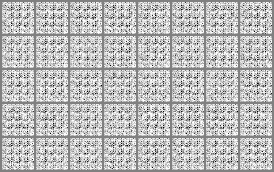

In [8]:
# 测试。
def run(epochs=100):
    # 初始化一个session
    print(x_train.shape)
    sess = K.get_session()
    # 拿到训练数据总条数
    l = x_train.shape[0]
    # 总条数减去余数，获得能整除BATCH_SIZE的总条数
    l -= l % BATCH_SIZE
    for epoch in range(epochs):
        np.random.shuffle(x_train)
        # 对于每一轮epoch，用x_train上的数据进行训练
        for batch_start in range(0, l, BATCH_SIZE):
            # 迭代式遍历x_train，batch依次被装填上x_train[0,32),x_train[32,64),...
            batch = x_train[batch_start: batch_start + BATCH_SIZE]
            # 生成形状为（32,128）的高斯随机数
            z_input = np.random.normal(loc=0., 
                                       scale=1., 
                                       size=(BATCH_SIZE, LATENT_SIZE))
            """核心语句：把sess，数据batch，高斯随机数传入.迭代式训练。
            """
            dloss, gloss = gan_feed(sess, batch, z_input)
        clear_output(wait=True)
        # 打印 轮数，dloss，gloss
        print('%d dloss: %2.2f gloss: %2.2f' % (epoch, dloss, gloss))
        f = BytesIO()
        # 传入我们训练好的generator，生成8列5行的展示图。
        poster(generator, 8, 5).save(f,'png')
        # 显示出来。
        display(Image(data=f.getvalue()))
run(1)

In [9]:
# run(30)

In [10]:
# f = BytesIO()
# poster(generator, 24, 12).save(f, 'png')
# display(Image(data=f.getvalue()))